In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (10,6)

In [73]:
str_files = ''
#Carrega os dados do arquivo .csv
#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'od.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

In [74]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']

In [75]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [76]:
trainingd

,cod_interaguas,valor,Altitude
data_coleta,,,
1978-01-31,139.5,3.700,571.5
1978-03-31,139.5,2.025,571.5
1978-05-31,139.5,4.350,571.5
1978-07-31,139.5,3.200,571.5
1978-09-30,139.5,2.425,571.5
...,...,...,...
2018-07-31,154.8,2.940,514.2
2018-09-30,154.8,2.202,514.2
2018-11-30,154.8,4.278,514.2


In [77]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas','Altitude'], axis=1)
trainingd


,valor
data_coleta,
1978-01-31,3.700
1978-03-31,2.025
1978-05-31,4.350
1978-07-31,3.200
1978-09-30,2.425
...,...
2018-07-31,2.940
2018-09-30,2.202
2018-11-30,4.278


In [78]:
trainingd.describe()

,valor
count,248.000000
mean,3.753310
std,1.105868
min,0.133333
25%,3.000000
50%,3.632000
75%,4.360000
max,8.410000


In [79]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlierinf = trainingd[(trainingds.valor < 0.96)]

outlierinf


primeiro_quartil: valor    3.0
Name: 0.25, dtype: float64
terceiro_quartil: valor    4.36
Name: 0.75, dtype: float64
fig: valor    1.36
dtype: float64
Inferior: valor    0.96
dtype: float64
Superior: valor    6.4
dtype: float64


C:\Users\Anderson\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1992-07-31,0.133333


In [80]:
#Seleciona os valores abaixo  do limite superior, ou seja, os outlier.
outliersup = trainingd[(trainingds.valor > 6.4)]

outliersup

C:\Users\Anderson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,valor
data_coleta,
1983-07-31,6.650
1987-03-31,6.450
1988-07-31,6.750
1989-03-31,6.500
1989-09-30,6.775
2019-03-31,8.410


In [81]:
#Substituição do outlier inferior pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] < inferior.valor] = 3.753310

outlierinf = trainingd[(trainingd.valor < inferior.valor)]

outlierinf

,valor
data_coleta,


In [82]:
#Substituição do outlier inferior pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] > superior.valor] = 3.753310

outlier = trainingd[(trainingd.valor > superior.valor)]

outlier

,valor
data_coleta,


In [83]:
trainingd

,valor
data_coleta,
1978-01-31,3.70000
1978-03-31,2.02500
1978-05-31,4.35000
1978-07-31,3.20000
1978-09-30,2.42500
...,...
2018-07-31,2.94000
2018-09-30,2.20200
2018-11-30,4.27800


In [84]:
#Dados completo.
data = trainingd.iloc[:,:].values
#treino (70%)
train = trainingd.iloc[0:174,:].values  
#teste (30%)
test = trainingd.iloc[174:,:].values 

testd = test

print('Completo:',len(data))
print('treino:',len(train))
print('teste:',len(test))
#print(testd)
data.shape

Completo: 248
treino: 174
teste: 74


(248, 1)

In [85]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
sc = MinMaxScaler()
train = sc.fit_transform(train)
test = sc.fit_transform(test)


In [86]:
#Prepara o conjunto de dados em X e y, considerando a janela de visualização (lags).
def prepara_dados(dados,lags):
    X = []
    y = []
    for i in range(lags, len(dados)):
        X.append(dados[i-lags:i, 0])
        y.append(dados[i, 0])
    return np.array(X), np.array(y)

#Calcula o MAPE
#Define função para calcular o MAPE
#def mape(y_pred,y_true):
 #   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore

1.0


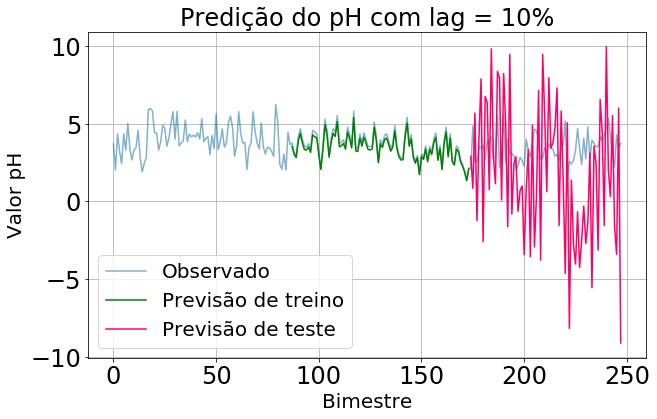

In [98]:
lags = 87 # Equivalente à 10% dos dados de treino.
#Prepara os dados de treinamento
train_X, train_y = prepara_dados(train, lags)
    
#Prepara os dados de teste
entradas = trainingd[len(trainingd) - len(test) - lags:].values
entradas = entradas.reshape(-1, 1)
entradas = sc.fit_transform(entradas)

test_X = []
for i in range(lags, lags+len(test)):
    test_X.append(entradas[i-lags:i, 0])
test_X = np.array(test_X)
    
#Cria o modelo
model = LinearRegression(normalize=True)

#Treina o modelo
model.fit(train_X,train_y)
score = model.score(train_X,train_y)
print(score)

#Dados de teste
previsoes = model.predict(test_X)
previsoes = previsoes.reshape(-1, 1)
previsoes = sc.inverse_transform(previsoes)

#Dados de treino
previsoes_treino = model.predict(train_X)
previsoes_treino = previsoes_treino.reshape(-1, 1)
previsoes_treino = sc.inverse_transform(previsoes_treino)

#Preparação para plotagem
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(previsoes_treino) + lags, :] = previsoes_treino
train_predict_plot.shape
    
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+lags:len(data), :] = previsoes

#Plotagem do gráfico
plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.plot(train_predict_plot, color = 'green', label = 'Previsão de treino')
plt.plot(test_predict_plot, color = '#ff0066', label = 'Previsão de teste')
plt.title('Predição do pH com lag = 10%')
plt.xlabel('Bimestre')
plt.ylabel('Valor pH')
plt.legend()
plt.grid()
plt.show()
    
#Calculo do erro da previsão
#mape(previsoes.mean(),test.mean())
test = sc.inverse_transform(test)
treino = sc.inverse_transform(train[lags: len(previsoes_treino) + lags, :])




In [99]:
print('Resultados com lag', lags)
print('\n')
print('MAPE TREINO:',round(mape(previsoes_treino,treino)[0],2),'%')
print('RMSE TREINO:',round(rmse(previsoes_treino,treino),2))
print('R TREINO:',round(r2(previsoes_treino,treino),2))
print('\n')
print('MAPE TESTE:',round(mape(previsoes,test)[0],2),'%')
print('RMSE TESTE:',round(rmse(previsoes,test),2))
print('R TESTE:',round(r2(previsoes,test),2))
print('\n')

Resultados com lag 87


MAPE TREINO: 0.0 %
RMSE TREINO: 0.0
R TREINO: 1.0


MAPE TESTE: 71.97 %
RMSE TESTE: 69.45
R TESTE: -15.27




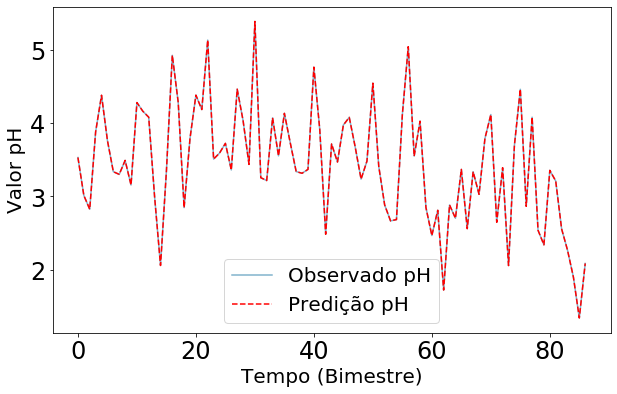

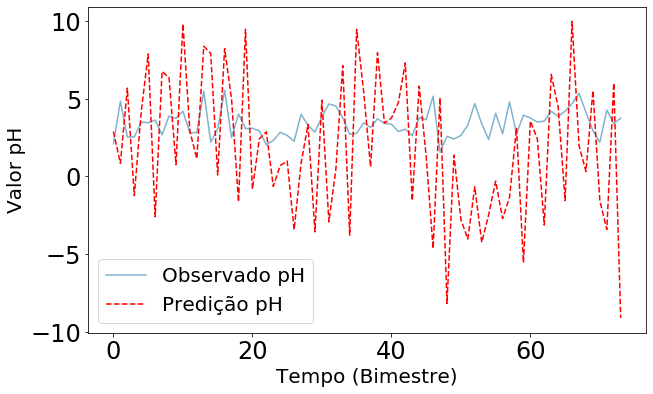

"\nprint(len(observado_treino_x))\nprint(len(observado_treino))\nprint(len(previsoes_treino))\n\n#Plotagem do gráfico\n#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')\nplt.scatter(observado_treino_x,observado_treino, color = 'red', label = 'Observado pH')\nplt.scatter(observado_treino_x,previsoes_treino, color = '#006699', label = 'Predição pH')\nplt.title('Predição do pH com lag = 10%')\nplt.xlabel('Observado pH')\nplt.ylabel('Predição pH')\n#plt.legend()\n#plt.grid()\nplt.show()\n"

In [100]:
train_y = train_y.reshape(-1, 1)
observado_treino = sc.inverse_transform(train_y)

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.plot(observado_treino, color = '#006699', alpha=0.5, label = 'Observado pH')
plt.plot(previsoes_treino, color = 'red',linestyle = '--', label = 'Predição pH')
#plt.title('Predição do pH com lag = 10%')
plt.xlabel('Tempo (Bimestre)')
plt.ylabel('Valor pH')
plt.legend()
#plt.grid()
plt.show()

observado_test = testd

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.plot(observado_test, color = '#006699', alpha=0.5, label = 'Observado pH')
plt.plot(previsoes, color = 'red',linestyle = '--', label = 'Predição pH')
#plt.title('Predição do pH com lag = 10%')
plt.xlabel('Tempo (Bimestre)')
plt.ylabel('Valor pH')
plt.legend()
#plt.grid()
plt.show()


'''
print(len(observado_treino_x))
print(len(observado_treino))
print(len(previsoes_treino))

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.scatter(observado_treino_x,observado_treino, color = 'red', label = 'Observado pH')
plt.scatter(observado_treino_x,previsoes_treino, color = '#006699', label = 'Predição pH')
plt.title('Predição do pH com lag = 10%')
plt.xlabel('Observado pH')
plt.ylabel('Predição pH')
#plt.legend()
#plt.grid()
plt.show()
'''

(248, 1)

174